Maximizaremos a seguinte função:

$ Min \hspace{0.5cm} C_1 \cdot GT_1 + C_2 \cdot GT_2 + CDef \cdot def + 0.01 \cdot Vvet $

sujeito a:

$ \hspace{2cm}  V_f = VI + AFL - Vtur - Vvert $ (Equação de Balanço Hídrico)

$ \hspace{2cm}  Carga = \rho \cdot Vtur + GT_1 + GT_2 + def $ (Equação de Demanda)

$ \hspace{3cm} 20 \le V_f \le 100 $

$ \hspace{3cm} 0 \le Vtur \le \infty $

$ \hspace{3cm} 0 \le Vvert \le \infty $

$ \hspace{3cm} 0 \le GT_1 \le 15 $

$ \hspace{3cm} 0 \le GT_2 \le 10 $

$ \hspace{3cm} 0 \le def \le \infty $


In [108]:
usina  = {
    "Nome": "UHE do Marcato",
    "Vmax": 100,
    "Vmin": 20,
    "Prod": 0.95,
    "Engol": 60
}


lista_uhe = []

usina  = {
    "Nome": "UHE do Marcato",
    "Vmax": 100,
    "Vmin": 20,
    "Prod": 0.95,
    "Engol": 60
}

lista_uhe.append(usina)

usina  = {
    "Nome": "UHE do Pedro",
    "Vmax": 300,
    "Vmin": 50,
    "Prod": 0.55,
    "Engol": 100
}

lista_uhe.append(usina)

print(lista_uhe)


lista_uhe = []


usina  = {
    "Nome": "UHE do Marcato",
    "Vmax": 100.,
    "Vmin": 20.,
    "Prod": 0.95,
    "Engol": 60.,
    "Afl": [
            [23, 16],
            [19, 14],
            [15, 11]
    ] #Alf stands for "Afluencia" with opmistic and pessimistic scenarios
}

lista_uhe.append(usina)

# vamos inserir as usinas de geração termica (GT_#)
usina  = {
    "Nome": "GT_1",
    "Capac": 15.,
    "Custo": 10.
}

lista_ute = []
lista_ute.append(usina)

usina  = {
    "Nome": "GT_2",
    "Capac": 10.,
    "Custo": 25.
}
lista_ute.append(usina)

#print(lista_ute)

# vamos insrir os dados de sistema

d_gerais = {
     "CDef": 5.,             #Custo de Deficit
     "Carga": [50., 50., 50.], #Cargas nos 3 mesesz
     "Nr_Disc": 3,             # Numero de discretizações
     "Nr_Est": 3,              #Numero de Estagios
     "Nr_Cen": 2               #Numero de Cenarios

 }

sistema = {
     "DGer": d_gerais,
     "UHE": lista_uhe,
     "UTE": lista_ute
 }

print(sistema["DGer"]["CDef"])


5.0


In [109]:
from cvxopt.modeling import variable, solvers, op 

Num_UHE = len(sistema["UHE"])
Num_UTE = len(sistema["UTE"])

vf = variable(Num_UHE, "Volume Final na Usina")
vt = variable(Num_UHE, "Volume da turbina na Usina")
vv = variable(Num_UHE, "Volume Vertido na Usina")
gt = variable(Num_UTE, "Geracao na Usina Termica")
deficit = variable(1, "Deficit de Energia no Sistema")

# Construção da Função Objetivo

fob = 0

for i, iusi in enumerate(sistema["UTE"]):
    fob += iusi['Custo']*gt[i]

fob += sistema["DGer"]["CDef"]*deficit[0]

for i, iusi in enumerate(sistema["UHE"]):
    fob += 0.01*vv[i]

print(fob)

#Definicao das restrições
restricoes = []

#Balanco Hidrico

for i, iusi in enumerate(sistema["UHE"]):
    restricoes.append(vf[i] == VI + Afl - vt[i] - vv[i])

# Atendimento à Demanda
AD = 0

for i, iusi in enumerate(sistema["UHE"]):
    AD += iusi["Prod"]*vt[i]

for i, iusi in enumerate(sistema["UTE"]):
    AD += gt[i]

AD += deficit[0]

restricoes.append(AD == sistema["DGer"]["Carga"][2])

print(restricoes[1])

# Restricoes de Canalizacao (limites inferiores e superiores de cada variavel de restricao)

for i, iusi in enumerate(sistema["UHE"]):
    restricoes.append(vf[i] >= iusi["Vmin"])
    restricoes.append(vf[i] <= iusi["Vmax"])
    restricoes.append(vf[i] >= 0)
    restricoes.append(vf[i] <= iusi["Engol"])
    restricoes.append(vf[i] >= 0)

for i, iusi in enumerate(sistema["UTE"]):
    restricoes.append(gt[i] >=0)
    restricoes.append(gt[i] <= iusi["Capac"])

restricoes.append(deficit[0] >= 0)



linear function of length 1
linear term: linear function of length 1
coefficient of variable(2,'Geracao na Usina Termica'):
[ 1.00e+01  2.50e+01]
coefficient of variable(1,'Deficit de Energia no Sistema'):
[ 5.00e+00]
coefficient of variable(1,'Volume Vertido na Usina'):
[ 1.00e-02]

scalar equality
constraint function:
affine function of length 1
constant term:
[-5.00e+01]
linear term: linear function of length 1
coefficient of variable(1,'Volume da turbina na Usina'):
[ 9.50e-01]
coefficient of variable(2,'Geracao na Usina Termica'):
[ 1.00e+00  1.00e+00]
coefficient of variable(1,'Deficit de Energia no Sistema'):
[ 1.00e+00]



## Resolvendo o problema de otimização

In [110]:

problema = op(fob, restricoes)

problema.solve('dense', 'glpk')

print(problema.status)
print("Custo Total: ", fob.value())

for i, iusi in enumerate(sistema["UHE"]):
    print(vf.name, i, " é ", vf[i].value(), "hm3")
    print(vt.name, i, " é ", vt[i].value(), "hm3")
    print(vv.name, i, " é ", vv[i].value(), "hm3")


for i, iusi in enumerate(sistema["UTE"]):
    print(gt.name, i, " é ", gt[i].value(), "MWmed")

print(deficit.name, " é ", deficit[0].value(), "MWmed")

for i, iusi in enumerate(sistema["UHE"]):
    print("O valor da água no usina ", i, " é:", restricoes[i].multiplier.value)

print("O custo marginal de operacao (CMO) ", restricoes[Num_UHE].multiplier.value)

print('-----------------------------------x--------------------------------------')

optimal
Custo Total:  [-2.26e-01]

Volume Final na Usina 0  é  [ 6.00e+01]
 hm3
Volume da turbina na Usina 0  é  [ 5.26e+01]
 hm3
Volume Vertido na Usina 0  é  [-2.26e+01]
 hm3
Geracao na Usina Termica 0  é  [ 0.00e+00]
 MWmed
Geracao na Usina Termica 1  é  [ 0.00e+00]
 MWmed
Deficit de Energia no Sistema  é  [ 0.00e+00]
 MWmed
O valor da água no usina  0  é: [-1.00e-02]

O custo marginal de operacao (CMO)  [ 1.05e-02]

-----------------------x-------------------------


## Encapsulando em uma função Simples

In [114]:
from cvxopt.modeling import variable, solvers, op

def despacho(sistema, VI, Afl, pote_de_corte, iest, imprimir):

    Num_UHE = len(sistema["UHE"])
    Num_UTE = len(sistema["UTE"])

    vf = variable(Num_UHE, "Volume Final na Usina")
    vt = variable(Num_UHE, "Volume da turbina na Usina")
    vv = variable(Num_UHE, "Volume Vertido na Usina")
    gt = variable(Num_UTE, "Geracao na Usina Termica")
    deficit = variable(1, "Deficit de Energia no Sistema")
    alpha = variable(1, "Custo Futuro")

    # Construção da Função Objetivo

    fob = 0

    for i, iusi in enumerate(sistema["UTE"]):
        fob += iusi['Custo']*gt[i]

    fob += sistema["DGer"]["CDef"]*deficit[0]

    for i, iusi in enumerate(sistema["UHE"]):
        fob += 0.01*vv[i]
    
    fob += 1*alpha[0]

    #Definicao das restrições
    restricoes = []

    #Balanco Hidrico

    for i, iusi in enumerate(sistema["UHE"]):
        restricoes.append(vf[i] == float(VI[i]) + float(Afl[i]) - vt[i] - vv[i])

    # Atendimento à Demanda
    AD = 0

    for i, iusi in enumerate(sistema["UHE"]):
        AD += iusi["Prod"]*vt[i]

    for i, iusi in enumerate(sistema["UTE"]):
        AD += gt[i]

    AD += deficit[0]

    restricoes.append(AD == sistema["DGer"]["Carga"][iest-2])

    # Restricoes de Canalizacao (limites inferiores e superiores de cada variavel de restricao)

    for i, iusi in enumerate(sistema["UHE"]):
        restricoes.append(vf[i] >= iusi["Vmin"])
        restricoes.append(vf[i] <= iusi["Vmax"])
        restricoes.append(vf[i] >= 0)
        restricoes.append(vf[i] <= iusi["Engol"])
        restricoes.append(vf[i] >= 0)

    for i, iusi in enumerate(sistema["UTE"]):
        restricoes.append(gt[i] >= 0)
        restricoes.append(gt[i] <= iusi["Capac"])

    restricoes.append(deficit[0] >= 0)

    restricoes.append(alpha[0] >= 0)

    for icorte in pote_de_corte:
        if icorte["Estagio"] == iest:
            equacao = 0
            for iusi in range(Num_UHE):
                equacao += float(icorte['Coefs'][iusi])*vf[iusi]
            equacao += float(icorte['Termo_Indep'])
            restricoes.append(alpha[0] >= equacao)

    problema = op(fob, restricoes)

    problema.solve('dense', 'glpk')

    DGer = {
        "Deficit": deficit[0].value()[0],
        "CMO": restricoes[Num_UHE].multiplier.value[0],
        "CustoTotal": fob.value()[0],
        "CustoFuturo": alpha.value[0]
    }
    
    lista_uhe = []

    for i, iusi in enumerate(sistema["UHE"]):
            resultado = {
                "vf": vf[i].value()[0],
                "vt": vt[i].value()[0],
                "vv": vv[i].value()[0],
                "CMA - Custo marginal da agua": restricoes[i].multiplier.value[0]
            }
            lista_uhe.append(resultado)

    lista_ute = []
    for i, iusi in enumerate(sistema["UTE"]):
            resultado = {
                "gt": gt[i].value()[0]
                }
            lista_ute.append(resultado)
    
    resultado = {
        "DGer": DGer,
        "UHE": lista_uhe,
        "UTE": lista_ute
    }


    if imprimir:
        print(iest, discretizacao, VI, icen, Afl)
        for i, iusi in enumerate(sistema["UHE"]):
            print(vf.name, i, " é ", vf[i].value(), "hm3")
            print(vt.name, i, " é ", vt[i].value(), "hm3")
            print(vv.name, i, " é ", vv[i].value(), "hm3")


        for i, iusi in enumerate(sistema["UTE"]):
            print(gt.name, i, " é ", gt[i].value(), "MWmed")

        print(deficit.name, " é ", deficit[0].value(), "MWmed")
        print(alpha.name, " é ", alpha[0].value(), "BRL")

        for i, iusi in enumerate(sistema["UHE"]):
            print("O valor da água no usina ", i, " é:", restricoes[i].multiplier.value)

        print("O custo marginal de operacao (CMO) ", restricoes[Num_UHE].multiplier.value)

        print('-----------------------x-------------------------')

    return resultado

2 (100.0,) [62] 1 [15]
Volume Final na Usina 0  é  [ 6.00e+01]
 hm3
Volume da turbina na Usina 0  é  [ 5.26e+01]
 hm3
Volume Vertido na Usina 0  é  [-3.56e+01]
 hm3
Geracao na Usina Termica 0  é  [ 0.00e+00]
 MWmed
Geracao na Usina Termica 1  é  [ 0.00e+00]
 MWmed
Deficit de Energia no Sistema  é  [ 0.00e+00]
 MWmed
Custo Futuro  é  [ 8.42e-01]
 BRL
O valor da água no usina  0  é: [-1.00e-02]

O custo marginal de operacao (CMO)  [ 1.05e-02]

-----------------------x-------------------------


{'DGer': {'Deficit': 0.0,
  'CMO': 0.010526315789473686,
  'CustoTotal': 0.48605263157895906,
  'CustoFuturo': 0.8423684210526433},
 'UHE': [{'vf': 60.0,
   'vt': 52.631578947368425,
   'vv': -35.631578947368425,
   'CMA - Custo marginal da agua': -0.01}],
 'UTE': [{'gt': 0.0}, {'gt': 0.0}]}

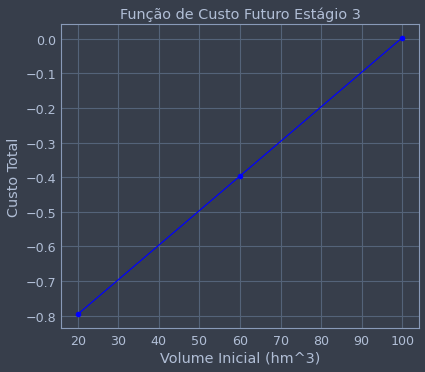

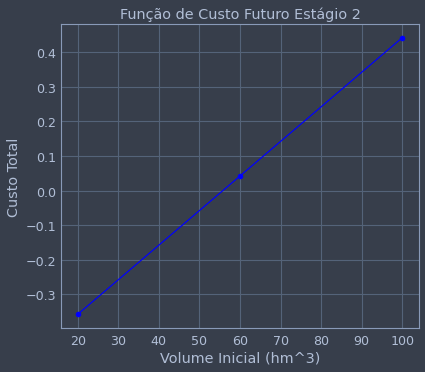

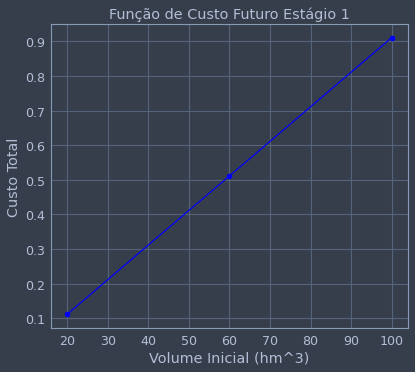

In [115]:
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme='onedork')


Num_UHE = len(sistema["UHE"])
Num_UTE = len(sistema["UTE"])

passo = 100/(sistema['DGer']["Nr_Disc"]-1)

discretizacoes = list(product(np.arange(0, 100+passo, passo), repeat = Num_UHE)) # o arange é exlusive [0, 150) ---> portanto ele não imprimirá o último elemento

pote_de_corte = []

for iest in np.arange(sistema["DGer"]["Nr_Est"], 0, -1):
    plt.figure(iest)
    plt.title(f'Função de Custo Futuro Estágio {iest}')
    plt.xlabel("Volume Inicial (hm^3)")
    plt.ylabel("Custo Total")
    eixox = []
    eixoy = []

    for discretizacao in discretizacoes:
        VI = []
        for i, iusi in enumerate(sistema["UHE"]):
            VI.append(iusi["Vmin"] + (iusi["Vmax"]-iusi["Vmin"])*discretizacao[i]/100)
        eixox.append(VI[0])
        media = 0
        media_cma = []
        for i, iusi in enumerate(sistema['UHE']):
            media_cma.append(0)


        for icen in np.arange(0, sistema["DGer"]["Nr_Cen"]):
            Afl = []
            for i, iusi in enumerate(sistema["UHE"]):
                Afl.append(iusi["Afl"][iest-1][icen])
                resultado = despacho(sistema, VI, Afl, pote_de_corte, iest+1, imprimir = False)
                #print(resultado)
                media += resultado['DGer']["CustoTotal"]
                for i, iusi in enumerate(resultado["UHE"]):
                    media_cma[i] += iusi["CMA - Custo marginal da agua"]

        media = media / sistema["DGer"]["Nr_Cen"]
        term_indep = media
        for i, iusi in enumerate(resultado["UHE"]):
            media_cma[i] += -media_cma[i] / sistema["DGer"]["Nr_Cen"]
            term_indep -= VI[i]*media_cma[i]
        corte = {
            "Estagio": iest,
            "Termo_Indep": term_indep,
            "Coefs": media_cma
        }
        pote_de_corte.append(corte)

        eixoy.append(media)
    plt.plot(eixox, eixoy, marker='o', color='blue')



despacho(sistema, [62], [15], pote_de_corte, 2, imprimir=True)

